# Section 2: Text classification

Setup and config the environment

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("This script is running on Google Colab.")
else:
    print("This script is not running on Google Colab.")

This script is running on Google Colab.


In [ ]:
if IN_COLAB:
  !pip install spacy
  !python -m spacy download en_core_web_sm
else:
  pass

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
if IN_COLAB:
  !pip install gensim
else:
  pass

In [ ]:
if IN_COLAB:
  !pip install transformers
else:
  pass

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import nltk
nltk.download('punkt')

import collections
from collections import defaultdict

import gensim.downloader
from gensim.models import KeyedVectors

import transformers
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import time

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import scipy
from scipy.spatial.distance import euclidean

RANDOM_SEED = 40419837
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Load 'stories.json' file

In [ ]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/')
  pth = '/content/drive/MyDrive/QUB MSc AI/ECS8054 - Natural Language Processing/\
Natural Language Processing - Final Assessment Project'
  print("Google Drive mounted successfully")

Mounted at /content/drive/
Google Drive mounted successfully


In [ ]:
with open(os.path.join(pth, 'stories.json'), 'r') as ifh:
    json_data = json.load(ifh)

df = pd.DataFrame(json_data)
df.head()

,index,genre,writer,quality,story_subject,action1,place,action2,story_object,ending,object_concept,story,question1,answer1,question2,answer2
0,0,thriller,Samuel Beckett,depressed,doctor,is originally from,Italy,save,worst enemy,sad,trombone,The shadowy arms of melancholy clung persisten...,Where was the protagonist's birthplace?,"""His origin lay nestled at the foot of the Alp...",What musical instrument is mentioned in the st...,"""A trombone, tarnished by time and disuse, lay..."
1,1,comedy,Lewis Carroll,rich,scientist,goes to,China,meet,sister,happy,dictionary,"Once there lived an affluent alchemist, boasti...",What does the Alchemist recognise about the fi...,"""He recognised the slice of golden eyes, the a...",How does the Alchemist feel towards his dictio...,"""He packed his graphite grey suitcase with ess..."
2,2,thriller,Samuel Beckett,angry,rockstar,lives in,France,meet,best friend,unexpected,centipede,Beneath the iron-grey veil of foreign skies re...,What did the entity long for?,"""His temperament, mirroring the azure ripples ...",What unexpected event altered the entity's jou...,"""But fate, in its quintessential unpredictabil..."
3,3,thriller,Enid Blyton,young,scientist,lives in,India,save,worst enemy,sad,lobster,"Once upon a time, in a land cradled in the arm...",Where did the man find himself one silent night?,"""The night when he held the essence of surviva...",What is a consistent companion to the man's me...,"""He relished the extraordinary robust flavour ..."
4,4,comedy,Charles Dickens,old,taxi driver,lives in,Texas,meet,best friend,unexpected,trolley,Upon a bright morning under the waving Lone St...,What did the gentleman find when he arrived at...,"""As he approached the familiar oak at the cres...",Why was his friend not at home to welcome him?,"""He opened it to find a note from his companio..."


In [ ]:
df.shape

(700, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           700 non-null    int64 
 1   genre           700 non-null    object
 2   writer          700 non-null    object
 3   quality         700 non-null    object
 4   story_subject   700 non-null    object
 5   action1         700 non-null    object
 6   place           700 non-null    object
 7   action2         700 non-null    object
 8   story_object    700 non-null    object
 9   ending          700 non-null    object
 10  object_concept  700 non-null    object
 11  story           700 non-null    object
 12  question1       700 non-null    object
 13  answer1         700 non-null    object
 14  question2       700 non-null    object
 15  answer2         700 non-null    object
dtypes: int64(1), object(15)
memory usage: 87.6+ KB


## 2.1 Text classification with Word2Vec

Data exploration and preparation

In [ ]:
stories = df['story']
print(stories)

0      The shadowy arms of melancholy clung persisten...
1      Once there lived an affluent alchemist, boasti...
2      Beneath the iron-grey veil of foreign skies re...
3      Once upon a time, in a land cradled in the arm...
4      Upon a bright morning under the waving Lone St...
                             ...                        
695    In a place where tropical plants grew wild and...
696    In a world far removed from the routine tranqu...
697    In the heart of the tropics, nestled within th...
698    Once upon a chilly waning autumn evening, bene...
699    In the mighty metropolis, where stacks of bric...
Name: story, Length: 700, dtype: object


In [ ]:
subjects = df['story_subject']
print(subjects)

0           doctor
1        scientist
2         rockstar
3        scientist
4      taxi driver
          ...     
695       rockstar
696         doctor
697      scientist
698         doctor
699      scientist
Name: story_subject, Length: 700, dtype: object


In [ ]:
subjects_count = df['story_subject'].value_counts()
print(subjects_count)


rockstar            151
doctor              149
local politician    138
scientist           136
taxi driver         126
Name: story_subject, dtype: int64


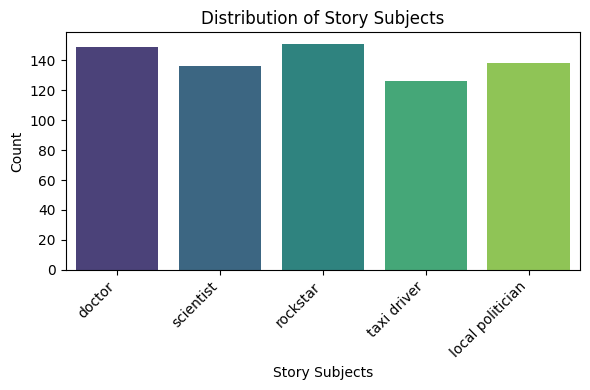

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='story_subject', hue='story_subject', data=df,
              palette='viridis', legend=False)
plt.xlabel('Story Subjects')
plt.ylabel('Count')
plt.title('Distribution of Story Subjects')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Label encoding

In [ ]:
label_encoder = LabelEncoder()

encoded_subjects = label_encoder.fit_transform(subjects)
print(encoded_subjects)

[0 3 2 3 4 1 4 0 4 1 3 4 3 0 0 2 4 2 2 2 2 0 2 1 2 1 1 0 2 3 2 2 2 3 4 2 1
 2 0 4 2 3 2 3 1 1 4 2 0 4 4 1 3 4 0 2 3 1 1 3 0 1 1 2 0 1 2 2 1 4 4 0 1 2
 3 3 4 4 3 0 1 0 1 0 4 0 0 4 3 1 1 4 3 4 0 4 1 4 2 3 0 0 3 3 4 3 3 2 4 1 1
 4 2 0 3 2 0 3 0 2 4 2 2 4 1 1 3 1 3 2 0 2 4 3 3 3 0 0 1 3 4 4 1 4 1 2 3 0
 1 3 3 2 4 4 0 0 1 2 0 2 3 0 3 0 4 3 3 3 4 1 3 1 3 3 0 1 4 4 0 2 2 3 2 1 0
 1 0 2 4 0 3 1 4 0 2 1 0 2 4 1 1 1 4 0 1 1 1 0 0 0 0 4 3 0 2 1 2 0 2 2 2 1
 1 1 2 3 4 3 3 0 0 1 2 4 3 3 0 3 1 1 1 3 1 4 0 2 3 2 4 4 3 2 4 3 1 3 3 1 3
 3 1 0 0 0 2 0 1 2 2 1 0 2 0 4 0 2 0 0 3 2 4 3 2 1 2 2 3 2 2 3 0 4 1 1 3 2
 4 2 3 1 1 0 4 2 3 0 0 4 1 4 4 3 4 2 2 4 0 4 4 1 0 4 2 3 4 2 0 1 1 0 2 1 2
 1 0 0 4 0 3 4 4 1 3 0 0 0 2 3 4 0 0 3 3 4 3 4 2 0 1 2 4 2 0 0 0 3 3 4 3 3
 2 1 4 0 2 3 0 1 2 2 0 3 2 0 1 1 1 0 4 0 4 4 2 2 2 3 3 2 4 3 1 2 0 1 2 1 1
 1 4 2 1 2 3 3 4 0 1 2 3 2 3 3 1 0 0 1 1 1 2 0 0 1 2 0 0 0 0 3 1 3 0 4 3 4
 0 1 3 0 0 4 0 4 0 1 0 2 2 2 3 0 2 3 3 3 3 4 4 2 2 1 0 1 2 3 0 2 4 0 3 4 0
 4 3 2 2 4 2 0 0 3 4 0 0 

In [ ]:
encoding_mapping = dict(zip(range(len(label_encoder.classes_)),
                            label_encoder.classes_))

print("Encoding Mapping:")
print(encoding_mapping)

Encoding Mapping:
{0: 'doctor', 1: 'local politician', 2: 'rockstar', 3: 'scientist', 4: 'taxi driver'}


In [ ]:
df['encoded_story_subject'] = encoded_subjects

df[['story_subject', 'encoded_story_subject']].sample(5)

,story_subject,encoded_story_subject
473,scientist,3
597,rockstar,2
77,taxi driver,4
105,scientist,3
557,rockstar,2


In [ ]:
subjects_labels = label_encoder.classes_
print(subjects_labels)

['doctor' 'local politician' 'rockstar' 'scientist' 'taxi driver']


Text processing

In [ ]:
# Load the English language model from spaCy
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2000000

# Define a function to process text
def process_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation from text
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text using spaCy
    doc = nlp(text)
    # Extract tokens from the document, excluding stop words
    tokens = [token.text for token in doc if not token.is_stop]
    return tokens


example_text = "The striped bats are hanging, on their feet, for best sleeping."
example_tokens = process_text(example_text)

print(example_tokens)

['striped', 'bats', 'hanging', 'feet', 'best', 'sleeping']


In [ ]:
processed_stories = []

for story in stories:
    tokens = process_text(story)
    processed_stories.append(tokens)

print(len(processed_stories))

700


Load the pre-trained 'word2vec-google-news-300' model

In [ ]:
filename = 'GoogleNews-vectors-negative300.bin.gz'
path = '/content/drive/MyDrive/QUB MSc AI/ECS8054 - Natural Language Processing/\
Natural Language Processing - Final Assessment Project'
pfn = os.path.join(path, filename)

if os.path.exists(pfn):
    word2vec_model = KeyedVectors.load_word2vec_format(pfn, binary=True)
    print("Word2Vec model loaded successfully.")
else:
    print("Word2Vec model not found locally. Downloading...")
    word2vec_model = gensim.downloader.load('word2vec-google-news-300')

    word2vec_model.save(pfn)
    print("Word2Vec model downloaded and saved locally.")

Word2Vec model loaded successfully.


Compute word embedding feature vectors

In [ ]:
# Initialize an empty list to store feature vectors
feature_vectors = []

# Iterate through each story
for story in processed_stories:
    # Extract embeddings for tokens in the story
    embeddings = [word2vec_model[token] for token in story if token in word2vec_model]

    # Compute average embedding if embeddings exist, otherwise append zero vector
    if embeddings:
        feature_vectors.append(np.mean(embeddings, axis=0))
    else:
        feature_vectors.append(np.zeros(word2vec_model.vector_size))

Splitting data

In [ ]:
print("Feature vectors:", len(feature_vectors))

print("\nEncoded Subjects:\n", encoded_subjects)
print(len(encoded_subjects))

Feature vectors: 700

Encoded Subjects:
 [0 3 2 3 4 1 4 0 4 1 3 4 3 0 0 2 4 2 2 2 2 0 2 1 2 1 1 0 2 3 2 2 2 3 4 2 1
 2 0 4 2 3 2 3 1 1 4 2 0 4 4 1 3 4 0 2 3 1 1 3 0 1 1 2 0 1 2 2 1 4 4 0 1 2
 3 3 4 4 3 0 1 0 1 0 4 0 0 4 3 1 1 4 3 4 0 4 1 4 2 3 0 0 3 3 4 3 3 2 4 1 1
 4 2 0 3 2 0 3 0 2 4 2 2 4 1 1 3 1 3 2 0 2 4 3 3 3 0 0 1 3 4 4 1 4 1 2 3 0
 1 3 3 2 4 4 0 0 1 2 0 2 3 0 3 0 4 3 3 3 4 1 3 1 3 3 0 1 4 4 0 2 2 3 2 1 0
 1 0 2 4 0 3 1 4 0 2 1 0 2 4 1 1 1 4 0 1 1 1 0 0 0 0 4 3 0 2 1 2 0 2 2 2 1
 1 1 2 3 4 3 3 0 0 1 2 4 3 3 0 3 1 1 1 3 1 4 0 2 3 2 4 4 3 2 4 3 1 3 3 1 3
 3 1 0 0 0 2 0 1 2 2 1 0 2 0 4 0 2 0 0 3 2 4 3 2 1 2 2 3 2 2 3 0 4 1 1 3 2
 4 2 3 1 1 0 4 2 3 0 0 4 1 4 4 3 4 2 2 4 0 4 4 1 0 4 2 3 4 2 0 1 1 0 2 1 2
 1 0 0 4 0 3 4 4 1 3 0 0 0 2 3 4 0 0 3 3 4 3 4 2 0 1 2 4 2 0 0 0 3 3 4 3 3
 2 1 4 0 2 3 0 1 2 2 0 3 2 0 1 1 1 0 4 0 4 4 2 2 2 3 3 2 4 3 1 2 0 1 2 1 1
 1 4 2 1 2 3 3 4 0 1 2 3 2 3 3 1 0 0 1 1 1 2 0 0 1 2 0 0 0 0 3 1 3 0 4 3 4
 0 1 3 0 0 4 0 4 0 1 0 2 2 2 3 0 2 3 3 3 3 4 4 2 2 1 0 1 2 

In [ ]:
X = np.array(feature_vectors)
y = np.array(encoded_subjects)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=RANDOM_SEED)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(560, 300) (70, 300) (70, 300)
(560,) (70,) (70,)


Text classification with Word2Vec

In [ ]:
model = LogisticRegression()

model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Validation Accuracy: 0.7
Test Accuracy: 0.6857142857142857


Model evaluation

In [ ]:
report = classification_report(y_test, y_test_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59        16
           1       0.71      0.56      0.63        18
           2       0.54      1.00      0.70         7
           3       0.87      0.87      0.87        15
           4       0.80      0.57      0.67        14

    accuracy                           0.69        70
   macro avg       0.69      0.72      0.69        70
weighted avg       0.71      0.69      0.68        70



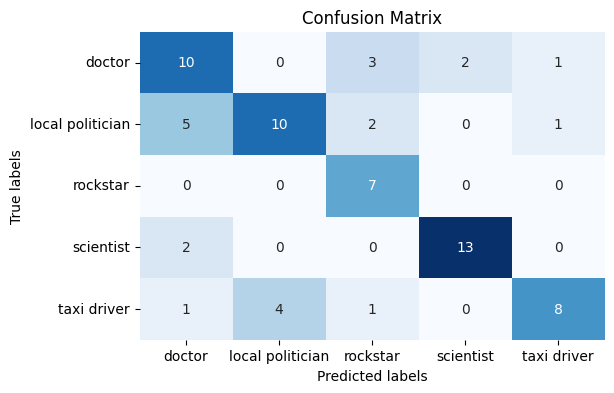

In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=subjects_labels, yticklabels=subjects_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## 2.2 Text classification with BERT



Create custom dataset class for sentiment analysis

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        # Initialize dataset with texts, labels, tokenizer, and maximum sequence length
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.texts)

    def __getitem__(self, idx):
        # Retrieve the text and label for the given index
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text using the provided tokenizer
        encoding = self.tokenizer(
            text, return_tensors='pt',
            max_length=self.max_length,
            padding='max_length',
            truncation=True)

        # Flatten and return input_ids, attention_mask, and label as tensors
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label)  # Convert label to tensor
        }

Build BERT Classifier

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        # Initialize the BERT-based classifier
        super(BERTClassifier, self).__init__()

        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.1)

        # Fully connected layer for classification
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        # Forward pass through BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Extract pooled output
        pooled_output = outputs.pooler_output

        # Apply dropout for regularization
        x = self.dropout(pooled_output)

        # Pass through fully connected layer for classification
        logits = self.fc(x)

        return logits

Define train() function

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    # Set the model to training mode
    model.train()

    # Initialize variables for tracking loss and accuracy
    total_loss = 0
    total_correct = 0
    total_samples = 0

    # Iterate through each batch in the data loader
    for batch in data_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Move input data and labels to the device (GPU or CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Calculate the loss
        loss = nn.CrossEntropyLoss()(outputs, labels)
        total_loss += loss.item()

        # Compute the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()  # Adjust learning rate

    # Compute average loss and accuracy
    return total_loss / len(data_loader), total_correct / total_samples

Define evaluate() function

In [ ]:
def evaluate(model, data_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables for tracking loss and accuracy
    total_loss = 0
    total_correct = 0
    total_samples = 0

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        # Iterate through each batch in the data loader
        for batch in data_loader:
            # Move input data and labels to the device (GPU or CPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass through the model
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Calculate the loss
            loss = nn.CrossEntropyLoss()(outputs, labels)
            total_loss += loss.item()

            # Compute the number of correct predictions
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    # Compute average loss and accuracy
    return total_loss / len(data_loader), total_correct / total_samples

Parameters

In [ ]:
bert_model_name = 'bert-base-uncased'
num_classes = len(subjects_labels) #5
max_length = 512
batch_size = 16
num_epochs = 20
learning_rate = 5e-6

Splitting data

In [ ]:
print("Stories:", stories)

print("\nEncoded Subjects:\n", encoded_subjects)
print(len(encoded_subjects))

Stories: 0      The shadowy arms of melancholy clung persisten...
1      Once there lived an affluent alchemist, boasti...
2      Beneath the iron-grey veil of foreign skies re...
3      Once upon a time, in a land cradled in the arm...
4      Upon a bright morning under the waving Lone St...
                             ...                        
695    In a place where tropical plants grew wild and...
696    In a world far removed from the routine tranqu...
697    In the heart of the tropics, nestled within th...
698    Once upon a chilly waning autumn evening, bene...
699    In the mighty metropolis, where stacks of bric...
Name: story, Length: 700, dtype: object

Encoded Subjects:
 [0 3 2 3 4 1 4 0 4 1 3 4 3 0 0 2 4 2 2 2 2 0 2 1 2 1 1 0 2 3 2 2 2 3 4 2 1
 2 0 4 2 3 2 3 1 1 4 2 0 4 4 1 3 4 0 2 3 1 1 3 0 1 1 2 0 1 2 2 1 4 4 0 1 2
 3 3 4 4 3 0 1 0 1 0 4 0 0 4 3 1 1 4 3 4 0 4 1 4 2 3 0 0 3 3 4 3 3 2 4 1 1
 4 2 0 3 2 0 3 0 2 4 2 2 4 1 1 3 1 3 2 0 2 4 3 3 3 0 0 1 3 4 4 1 4 1 2 3 0
 1 3

In [ ]:
X = np.array(stories)
y = np.array(encoded_subjects)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=RANDOM_SEED)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(560,) (70,) (70,)
(560,) (70,) (70,)


Initialize tokenizer, dataset, and data loader

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_dataset = TextClassificationDataset(X_train, y_train, tokenizer, max_length)
val_dataset = TextClassificationDataset(X_val, y_val, tokenizer, max_length)
test_dataset = TextClassificationDataset(X_test, y_test, tokenizer, max_length)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(val_dataset, batch_size=batch_size)

Set up the device and model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected device:", device)

model = BERTClassifier(bert_model_name, num_classes).to(device)

Selected device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Set up optimizer and learning rate scheduler

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                            num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model Training

In [ ]:
start_time = time.time()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Iterate over epochs
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Perform training for the current epoch and calculate training loss and accuracy
    train_loss, train_accuracy = train(model, train_dataloader, optimizer,
                                       scheduler, device)

    # Evaluate the model on validation data and calculate validation loss and accuracy
    val_loss, val_accuracy = evaluate(model, val_dataloader, device)

    # Print training and validation metrics for the current epoch
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}\n")

    # Append training and validation metrics to respective lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

end_time = time.time()
elapsed_time = end_time - start_time  # Calculate the total runtime
print(f"\nTotal runtime: {elapsed_time} seconds")

Epoch 1/20
Training Loss: 1.6182, Accuracy: 0.2107
Validation Loss: 1.6042, Accuracy: 0.2143

Epoch 2/20
Training Loss: 1.5587, Accuracy: 0.3089
Validation Loss: 1.5172, Accuracy: 0.4286

Epoch 3/20
Training Loss: 1.4135, Accuracy: 0.4804
Validation Loss: 1.3439, Accuracy: 0.4857

Epoch 4/20
Training Loss: 1.2130, Accuracy: 0.6054
Validation Loss: 1.1069, Accuracy: 0.6714

Epoch 5/20
Training Loss: 1.0198, Accuracy: 0.7393
Validation Loss: 0.9185, Accuracy: 0.8000

Epoch 6/20
Training Loss: 0.8304, Accuracy: 0.8643
Validation Loss: 0.7567, Accuracy: 0.8857

Epoch 7/20
Training Loss: 0.6552, Accuracy: 0.9411
Validation Loss: 0.6092, Accuracy: 0.9286

Epoch 8/20
Training Loss: 0.5078, Accuracy: 0.9696
Validation Loss: 0.4827, Accuracy: 0.9143

Epoch 9/20
Training Loss: 0.4035, Accuracy: 0.9750
Validation Loss: 0.4068, Accuracy: 0.9286

Epoch 10/20
Training Loss: 0.3177, Accuracy: 0.9857
Validation Loss: 0.3334, Accuracy: 0.9571

Epoch 11/20
Training Loss: 0.2628, Accuracy: 0.9929
Validat

Visualization of performance over epochs

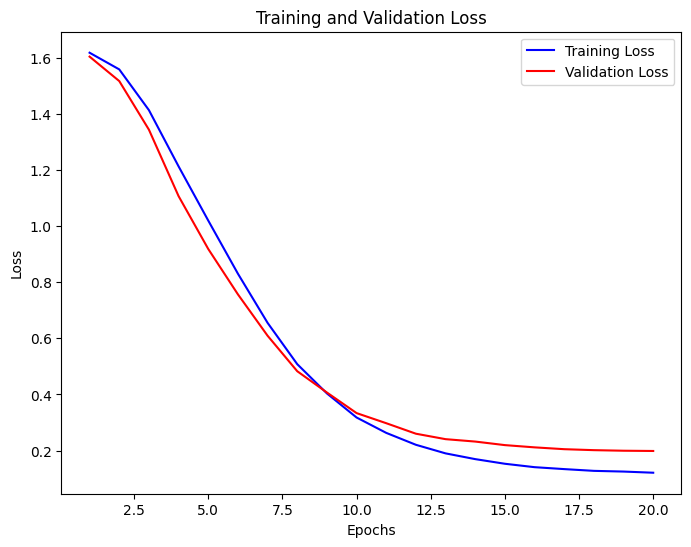

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

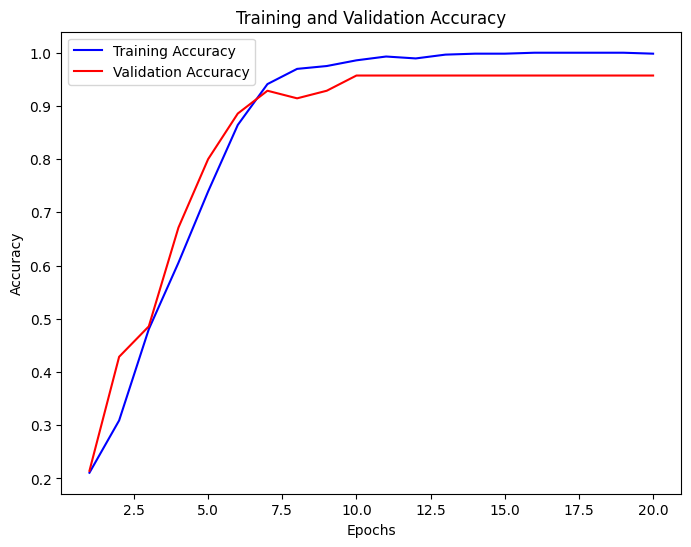

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Model Evaluation

In [ ]:
test_losses = []
test_accuracies = []
test_predictions = []
test_actual_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)  # Move input IDs to device (GPU/CPU)
        attention_mask = batch['attention_mask'].to(device)  # Move attention masks to device
        labels = batch['label'].to(device)  # Move labels to device
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Forward pass
        loss = nn.CrossEntropyLoss()(outputs, labels)  # Calculate loss
        test_losses.append(loss.item())  # Append loss to test_losses list
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        test_predictions.extend(predicted.cpu().tolist())  # Extend test_predictions list
        test_actual_labels.extend(labels.cpu().tolist())  # Extend test_actual_labels list

test_accuracy = accuracy_score(test_actual_labels, test_predictions)  # Calculate test accuracy
test_accuracies.append(test_accuracy)  # Append test accuracy to test_accuracies list

# Generate classification report
classification_rep = classification_report(test_actual_labels, test_predictions, zero_division=1)

# Print test loss, accuracy, and classification report
print(f"Testing Loss: {np.mean(test_losses):.4f}, Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(classification_rep)

Testing Loss: 0.1983, Accuracy: 0.9571
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       1.00      1.00      1.00        13
           2       0.94      0.94      0.94        18
           3       0.93      1.00      0.96        13
           4       0.92      0.92      0.92        12

    accuracy                           0.96        70
   macro avg       0.96      0.96      0.96        70
weighted avg       0.96      0.96      0.96        70



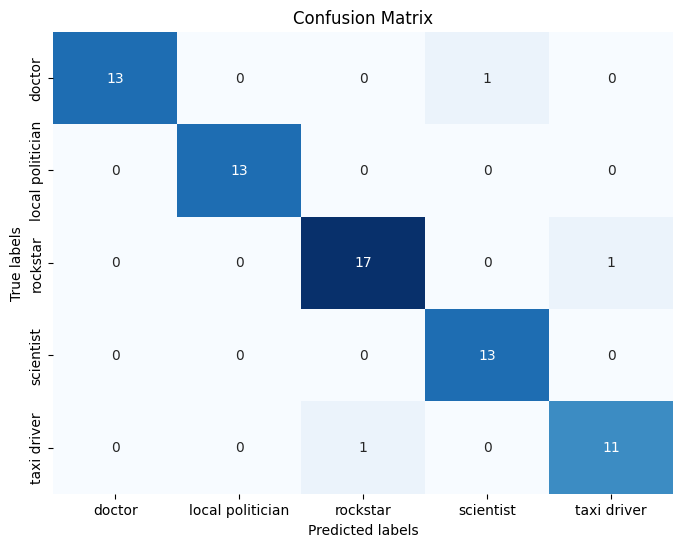

In [ ]:
conf_matrix = confusion_matrix(test_actual_labels, test_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=subjects_labels, yticklabels=subjects_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()